In [13]:
import numpy as np
import pandas as pd
from datetime import *

import statsmodels.api as sm
import statsmodels.formula.api as smf

from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.linear_model import LinearRegression

from sklearn.metrics import r2_score

import pylab as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

## least square practice

In [14]:
X = np.random.randn(100, 3)
beta = np.array([1, 2, 3])
y = np.dot(X, beta) + 0.01 * np.random.randn(100)
LinearRegression().fit(X, y).coef_

array([0.9996417 , 1.99999653, 3.00127008])

In [2]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

print(tf.__version__)

2.1.0


## Get data

In [3]:
with open('steps.dat', 'r') as handle:
    steps = handle.readline().strip().split()
steps_ = [f's{i}' for i in range(len(steps))]

In [4]:
df = pd.read_csv(
    'combined_data_step_7.csv',
    dtype={'fips': str}).set_index('fips')
df.rename(columns={a: b for a, b in zip(steps, steps_)}, inplace=True)
df.head()

,65yrs,minority,black,hispanic,population,perc_65yrs,perc_minority,perc_black,perc_hispanic,poverty,...,s21,s22,s23,s24,s25,s26,s27,s28,s29,covid
fips,,,,,,,,,,,,,,,,,,,,,
01001,8924,13262,11237,1671,55869,0.159731,0.237377,0.201131,0.029909,7587,...,45.0,62.0,61.0,241.0,91.0,54.0,80.0,85.0,65.0,2126
01003,46830,28036,19593,10534,223234,0.209780,0.125590,0.087769,0.047188,21069,...,270.0,235.0,210.0,295.0,430.0,571.0,142.0,160.0,287.0,6768
01005,4861,12552,11906,1117,24686,0.196913,0.508466,0.482298,0.045248,6788,...,-2.0,-8.0,4.0,210.0,52.0,39.0,21.0,35.0,54.0,1055
01007,3733,5203,4763,623,22394,0.166696,0.232339,0.212691,0.027820,4400,...,20.0,27.0,26.0,52.0,26.0,24.0,48.0,49.0,53.0,861
01009,10814,2414,978,5582,57826,0.187009,0.041746,0.016913,0.096531,7527,...,73.0,58.0,52.0,428.0,69.0,44.0,49.0,103.0,118.0,2009


In [5]:
steps_vec = [x.split('-') for x in steps]
steps = [f'2020-{m.zfill(2)}-{d.zfill(2)}' for m, d in steps_vec]

last = datetime.strptime(steps[-1], '%Y-%m-%d')
next_1 = (last + timedelta(days=7)).date()
next_2 = (last + timedelta(days=14)).date()

print(next_1, next_2)

2020-10-31 2020-11-07


In [6]:
df['urban_risk'] = df['perc_urban_pop'] * (df['risk_flu'] - df['risk_flu'].min())
covariates = [
    'population', 
    'perc_65yrs', 
    'perc_minority', 
    'perc_black', 
    'perc_hispanic', 
    'perc_poverty', 
    'perc_urban_pop',
    'income',
    'risk', 
    'risk_flu',
    'urban_risk'
]

df_z = df[steps_].copy()
for c in covariates:
    mean, std = df[c].mean(), df[c].std()
    df_z[c] = (df[c] - mean) / std
df_z.head()

,s0,s1,s2,s3,s4,s5,s6,s7,s8,s9,...,perc_65yrs,perc_minority,perc_black,perc_hispanic,perc_poverty,perc_urban_pop,income,risk,risk_flu,urban_risk
fips,,,,,,,,,,,,,,,,,,,,,
01001,12,7.0,6.0,11.0,9.0,23.0,42.0,45.0,61.0,43.0,...,-0.794106,0.512705,0.741329,-0.489703,-0.225017,0.535824,0.480936,0.984276,1.006875,0.666999
01003,29,37.0,43.0,38.0,34.0,35.0,38.0,19.0,10.0,21.0,...,0.257409,-0.180113,-0.042334,-0.365711,-0.883379,0.526204,0.353735,1.225361,1.296454,0.817850
01005,2,7.0,9.0,14.0,11.0,15.0,21.0,26.0,45.0,40.0,...,-0.012923,2.192825,2.685016,-0.379632,2.589482,-0.291414,-1.333023,0.221392,0.420657,-0.240836
01007,4,9.0,13.0,8.0,8.0,3.0,5.0,8.0,14.0,5.0,...,-0.647773,0.481481,0.821243,-0.504693,1.091708,-0.310652,-0.483902,0.308118,0.436170,-0.249735
01009,10,2.0,8.0,11.0,9.0,4.0,1.0,4.0,12.0,9.0,...,-0.221003,-0.699751,-0.532156,-0.011632,-0.323771,-1.003223,-0.167862,0.566669,0.617627,-0.724261


## GLM

In [7]:
cov_prefix = 'population+perc_65yrs+perc_minority+perc_black+perc_hispanic+perc_poverty+income+'
cov = cov_prefix + 'perc_urban_pop+risk_flu+urban_risk'

In [8]:
cors = []
for i in range(len(steps_)):
    cur = steps_[i]
    formula = f'{cur}~{cov}'

    # Model fitting
    model = smf.glm(
        formula=formula,
        data=df_z,
        family=sm.families.Poisson(sm.families.links.log())
    ).fit()
    print(f'{model.summary()}\n\n')
    
    prd = model.predict()
    cor = pd.DataFrame(
        data={'prd': prd, 'grd': df_z[cur].values}, 
        index=df.index).corr().loc['prd', 'grd']
    print(cor)
    cors.append(cor)
    
    df_z[cur + '_p'] = model.predict()

                 Generalized Linear Model Regression Results                  
Dep. Variable:                     s0   No. Observations:                 3094
Model:                            GLM   Df Residuals:                     3083
Model Family:                 Poisson   Df Model:                           10
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -2.1220e+05
Date:                Mon, 02 Nov 2020   Deviance:                   4.1454e+05
Time:                        16:24:00   Pearson chi2:                 7.18e+05
No. Iterations:                     8                                         
Covariance Type:            nonrobust                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          2.0954      0.007    280.

                 Generalized Linear Model Regression Results                  
Dep. Variable:                     s6   No. Observations:                 3094
Model:                            GLM   Df Residuals:                     3083
Model Family:                 Poisson   Df Model:                           10
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                   -inf
Date:                Mon, 02 Nov 2020   Deviance:                   1.7663e+05
Time:                        16:24:00   Pearson chi2:                 3.51e+05
No. Iterations:                     8                                         
Covariance Type:            nonrobust                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          2.4768      0.007    357.

                 Generalized Linear Model Regression Results                  
Dep. Variable:                    s10   No. Observations:                 3094
Model:                            GLM   Df Residuals:                     3083
Model Family:                 Poisson   Df Model:                           10
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                   -inf
Date:                Mon, 02 Nov 2020   Deviance:                   1.6409e+05
Time:                        16:24:00   Pearson chi2:                 2.60e+05
No. Iterations:                     8                                         
Covariance Type:            nonrobust                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          2.5415      0.007    370.

                 Generalized Linear Model Regression Results                  
Dep. Variable:                    s14   No. Observations:                 3094
Model:                            GLM   Df Residuals:                     3083
Model Family:                 Poisson   Df Model:                           10
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                   -inf
Date:                Mon, 02 Nov 2020   Deviance:                   2.7150e+05
Time:                        16:24:01   Pearson chi2:                 3.78e+05
No. Iterations:                     8                                         
Covariance Type:            nonrobust                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          3.2916      0.005    687.

                 Generalized Linear Model Regression Results                  
Dep. Variable:                    s18   No. Observations:                 3094
Model:                            GLM   Df Residuals:                     3083
Model Family:                 Poisson   Df Model:                           10
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                   -inf
Date:                Mon, 02 Nov 2020   Deviance:                   2.0461e+05
Time:                        16:24:01   Pearson chi2:                 2.73e+05
No. Iterations:                     7                                         
Covariance Type:            nonrobust                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          3.5871      0.004    908.

                 Generalized Linear Model Regression Results                  
Dep. Variable:                    s22   No. Observations:                 3094
Model:                            GLM   Df Residuals:                     3083
Model Family:                 Poisson   Df Model:                           10
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                   -inf
Date:                Mon, 02 Nov 2020   Deviance:                   1.9202e+05
Time:                        16:24:01   Pearson chi2:                 2.63e+05
No. Iterations:                     7                                         
Covariance Type:            nonrobust                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          3.5089      0.004    860.

                 Generalized Linear Model Regression Results                  
Dep. Variable:                    s28   No. Observations:                 3094
Model:                            GLM   Df Residuals:                     3083
Model Family:                 Poisson   Df Model:                           10
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                   -inf
Date:                Mon, 02 Nov 2020   Deviance:                   1.8693e+05
Time:                        16:24:02   Pearson chi2:                 2.18e+05
No. Iterations:                     6                                         
Covariance Type:            nonrobust                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          4.0089      0.003   1367.

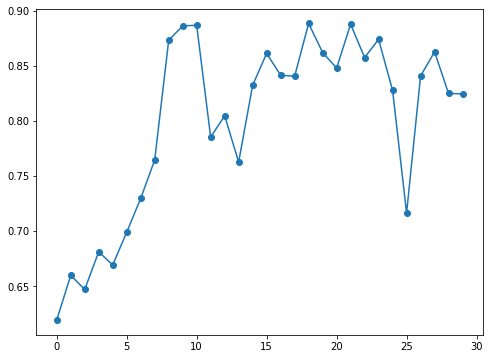

In [9]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
ax.plot(cors, marker='o')

## Forcasting

### make tensorflow regressor a little easier to use

In [10]:
class tfRegr:
    
    def __init__(self, 
                 epoch=100, 
                 verbose=False, 
                 validation_split=0.2, 
                 learning_rate=.1):
        
        self.normalizer = preprocessing.Normalization()
        self.ep = epoch
        self.vb = verbose
        self.vs = validation_split
        self.lr = learning_rate
    
    def fit(self, X, y):
        self.normalizer.adapt(X)

        self.model = tf.keras.Sequential([
            self.normalizer,
            layers.Dense(units=1)
        ])

        self.model.compile(
            optimizer=tf.optimizers.Adam(learning_rate=self.lr),
            loss='mean_absolute_error'
        )

        self.history = self.model.fit(
            X, y,
            epochs=self.ep,
            verbose=self.vb, # logging
            validation_split=self.vs # Calculate validation results on a fraction of the training data
        )
        return self.model

## Linearly combined predictors

In [27]:
def predict_k_steps(k=1, plan='plain'):

    regr_names = ['RF', 'ET', 'TF'] 
    regrs = {
        'RF': RandomForestRegressor(min_samples_split=2), 
        'ET': ExtraTreesRegressor(min_samples_split=2), 
        'TF': tfRegr(),
    }
    weights = np.array([1, 1, 1]) / 3.
    r2s = {regr_name: [] for regr_name in regr_names}
    r2s['weighted'] = []
    
    
    for i in range(k, len(steps_)):

        cur_idx = int(steps_[i][1:])
        prv, cur, nxt = steps_[i - k], steps_[i], f's{cur_idx + k}'

        print(f'{steps[i]}:')

        # Training regressor
        if plan == 'plain':
            cols = [f's{cur_idx - k}'] + [f's{cur_idx - k}_p']
        elif plan == 'tweak':
            cols = [f's{cur_idx - k}'] + [f's{cur_idx - i}_p' for i in range(k)]
        else:
            print('wrong plan name')
            return
        
        X_train = df_data[cols].values
        y_train = df_data[cur].values 

        B = []
        for regr_name in regr_names:
            regr = regrs[regr_name]
            regr = regr.fit(X_train, y_train)

            # Predicting next k step
            if plan == 'plain':
                cols = [cur] + [f's{cur_idx}_p']
            elif plan == 'tweak':
                cols = [cur] + [f's{cur_idx - i}_p' for i in range(k)]
    
            X_nxt = df_data[cols].values
            y_nxt = regr.predict(X_nxt)
            
            y_nxt = y_nxt.flatten()

            df_data[cur + f'_{k}p{regr_name}'] = y_nxt
            sum_nxt = y_nxt.sum()
            
            #===============================
            #===============================
            B.append(y_nxt)
            #===============================
            #===============================

            # evaluating and showing results
            if i < len(steps_) - k:
                y_test = df_data[nxt].values
                r2 = r2_score(y_test, y_nxt)
                r2s[regr_name].append(r2)
                
                diff_col = f'{cur}_{k}p{regr_name}_diff'
                df_data[diff_col] = y_test - y_nxt
                
                sum_grd = y_test.sum()
                print(f'\t{regr_name}, next {k}: sum = {sum_grd:.0f}, predicted sum = {sum_nxt:.0f}, r2 = {r2: .3f}')
            else:
                print(f'\t{regr_name}, next {k}: predicted sum = {sum_nxt:.0f}')
            
        #===============================
        #===============================
        B = np.array(B).T
        y_nxt_weighted = np.dot(B, weights)
        sum_nxt_weighted = y_nxt_weighted.sum()
        df_data[cur + f'_{k}pWeighted'] = y_nxt_weighted
        if i < len(steps_) - k:
            y_test = df_data[nxt].values
            
            #=================================================
            weights = LinearRegression().fit(B, y_test).coef_
            #=================================================
            
            r2 = r2_score(y_test, y_nxt_weighted)
            r2s['weighted'].append(r2)

            diff_col = f'{cur}_{k}pWeighted_diff'
            df_data[diff_col] = y_test - y_nxt_weighted

            sum_grd = y_test.sum()
            print(f'\tWeighted, next {k}: sum = {sum_grd:.0f}, predicted sum = {sum_nxt_weighted:.0f}, r2 = {r2: .3f}')
            #====================================
            print([f'{w:.3f}' for w in weights])
            #====================================
        else:
            print(f'\tWeighted, next {k}: predicted sum = {sum_nxt_weighted:.0f}')
        #===============================
        #===============================

    
    print(f'next {k} week r2s')
    for regr_name, r2_arr in r2s.items():
        r2_arr = np.array(r2_arr)
        print(f'\t{regr_name}: {r2_arr.mean(): .3f}')

In [28]:
df_data = df_z[[f's{i}' for i in range(len(steps_))] + [f's{i}_p' for i in range(len(steps_))]].copy()
plan = 'plain'

predict_k_steps(k=1, plan=plan)   
# predict_k_steps(k=2, plan=plan)

df_data.to_csv(f'prediction_{plan}_weighted.csv', float_format='%.2f')

2020-04-11:
	RF, next 1: sum = 202912, predicted sum = 166921, r2 =  0.901
	ET, next 1: sum = 202912, predicted sum = 168550, r2 =  0.896
	TF, next 1: sum = 202912, predicted sum = 138209, r2 =  0.800
	Weighted, next 1: sum = 202912, predicted sum = 157893, r2 =  0.877
['0.580', '0.182', '0.634']
2020-04-18:
	RF, next 1: sum = 206731, predicted sum = 191636, r2 =  0.905
	ET, next 1: sum = 206731, predicted sum = 188361, r2 =  0.903
	TF, next 1: sum = 206731, predicted sum = 170330, r2 =  0.901
	Weighted, next 1: sum = 206731, predicted sum = 253460, r2 =  0.836
['0.312', '0.028', '0.772']
2020-04-25:
	RF, next 1: sum = 192584, predicted sum = 217387, r2 =  0.835
	ET, next 1: sum = 192584, predicted sum = 214377, r2 =  0.830
	TF, next 1: sum = 192584, predicted sum = 188659, r2 =  0.894
	Weighted, next 1: sum = 192584, predicted sum = 219467, r2 =  0.857
['-0.577', '0.175', '1.385']
2020-05-02:
	RF, next 1: sum = 175327, predicted sum = 179013, r2 =  0.910
	ET, next 1: sum = 175327, pre

	TF, next 1: sum = 456580, predicted sum = 429159, r2 =  0.923
	Weighted, next 1: sum = 456580, predicted sum = 474066, r2 =  0.927
['-0.474', '0.553', '1.072']
2020-10-24:
	RF, next 1: predicted sum = 532785
	ET, next 1: predicted sum = 544901
	TF, next 1: predicted sum = 516228
	Weighted, next 1: predicted sum = 602202
next 1 week r2s
	RF:  0.856
	ET:  0.848
	TF:  0.869
	weighted:  0.829


In [29]:
df_data = df_z[[f's{i}' for i in range(len(steps_))] + [f's{i}_p' for i in range(len(steps_))]].copy()
plan = 'tweak'

predict_k_steps(k=1, plan=plan)   
# predict_k_steps(k=2, plan=plan)

df_data.to_csv(f'prediction_{plan}_weighted.csv', float_format='%.2f')

2020-04-11:
	RF, next 1: sum = 202912, predicted sum = 176718, r2 =  0.903
	ET, next 1: sum = 202912, predicted sum = 175087, r2 =  0.894
	TF, next 1: sum = 202912, predicted sum = 152266, r2 =  0.818
	Weighted, next 1: sum = 202912, predicted sum = 168024, r2 =  0.886
['0.809', '-0.161', '0.681']
2020-04-18:
	RF, next 1: sum = 206731, predicted sum = 196849, r2 =  0.898
	ET, next 1: sum = 206731, predicted sum = 191192, r2 =  0.897
	TF, next 1: sum = 206731, predicted sum = 173139, r2 =  0.903
	Weighted, next 1: sum = 206731, predicted sum = 246265, r2 =  0.840
['-0.244', '0.226', '1.188']
2020-04-25:
	RF, next 1: sum = 192584, predicted sum = 214926, r2 =  0.872
	ET, next 1: sum = 192584, predicted sum = 216734, r2 =  0.852
	TF, next 1: sum = 192584, predicted sum = 192091, r2 =  0.893
	Weighted, next 1: sum = 192584, predicted sum = 224597, r2 =  0.846
['0.354', '-0.006', '0.576']
2020-05-02:
	RF, next 1: sum = 175327, predicted sum = 182189, r2 =  0.944
	ET, next 1: sum = 175327, p

	TF, next 1: sum = 456580, predicted sum = 415774, r2 =  0.916
	Weighted, next 1: sum = 456580, predicted sum = 464529, r2 =  0.921
['-0.320', '0.355', '1.146']
2020-10-24:
	RF, next 1: predicted sum = 525340
	ET, next 1: predicted sum = 531910
	TF, next 1: predicted sum = 502720
	Weighted, next 1: predicted sum = 597297
next 1 week r2s
	RF:  0.865
	ET:  0.852
	TF:  0.872
	weighted:  0.766


In [63]:
def get_best(k, methods):
    df_diff_compare = pd.DataFrame(index=df_data.index)
    for method in methods:
        diff_cols = [f's{i}_1p{method}_diff' for i in range(max(1, k-1), k)]
        df_data_diff = df_data[diff_cols]
        if not df_data_diff.empty:
            df_diff_compare[method] = (df_data_diff ** 2).mean(axis=1).pow(.5)
    
    if df_diff_compare.empty:
        df_diff_compare['best'] = 'ET'
    else:
        df_diff_compare['best'] = df_diff_compare.idxmin(axis=1)
    
    return df_diff_compare['best']

In [64]:
def get_mse_summary(df_data, horizon, methods):
    
    results = {method: [] for method in methods}
    for i in range(1, len(steps)):
        for method in methods:
            diff_col = f's{i}_1p{method}_diff'
            if diff_col in df_data:
                diff = df_data[diff_col]
                mse = np.sqrt((diff**2).mean())
                results[method].append(mse)
                print(f'{i}, {method}: {mse:.0f}')
        print('\n')

    for key, val in results.items():
        print(f'{key} average: {np.mean(val):.0f}')

In [66]:
plan = 'plain'
df_data = pd.read_csv(f'prediction_{plan}_weighted.csv', dtype={'fips': str}).set_index('fips')
methods = ['ET', 'RF', 'TF', 'Weighted', 'Best']

for k in range(1, len(steps)):
    best_regrs = get_best(k, methods[:-1])
    # print(best_regrs)
    best_values = []
    for idx in best_regrs.index:
        method = best_regrs.loc[idx]
        col = f's{k}_1p{method}'
        val = df_data.loc[idx, col]
        best_values.append(val)
    df_data[f's{k}_1pBest'] = best_values
    if f's{k + 1}' in df_data:
        df_data[f's{k}_1pBest_diff'] = df_data[f's{k}_1pBest'] - df_data[f's{k + 1}']
get_mse_summary(df_data, 1, methods)

1, ET: 137
1, RF: 134
1, TF: 190
1, Weighted: 149
1, Best: 137


2, ET: 123
2, RF: 121
2, TF: 124
2, Weighted: 160
2, Best: 118


3, ET: 141
3, RF: 139
3, TF: 112
3, Weighted: 130
3, Best: 119


4, ET: 69
4, RF: 93
4, TF: 91
4, Weighted: 96
4, Best: 92


5, ET: 74
5, RF: 74
5, TF: 63
5, Weighted: 71
5, Best: 72


6, ET: 84
6, RF: 81
6, TF: 63
6, Weighted: 67
6, Best: 62


7, ET: 81
7, RF: 80
7, TF: 70
7, Weighted: 75
7, Best: 72


8, ET: 71
8, RF: 77
8, TF: 62
8, Weighted: 67
8, Best: 68


9, ET: 99
9, RF: 105
9, TF: 87
9, Weighted: 85
9, Best: 98


10, ET: 145
10, RF: 155
10, TF: 151
10, Weighted: 137
10, Best: 138


11, ET: 147
11, RF: 204
11, TF: 195
11, Weighted: 115
11, Best: 132


12, ET: 188
12, RF: 210
12, TF: 211
12, Weighted: 333
12, Best: 328


13, ET: 265
13, RF: 240
13, TF: 195
13, Weighted: 243
13, Best: 241


14, ET: 180
14, RF: 200
14, TF: 221
14, Weighted: 309
14, Best: 227


15, ET: 265
15, RF: 196
15, TF: 210
15, Weighted: 204
15, Best: 216


16, ET: 130
16, RF: 137


## Get US Count

In [53]:
srs = []
grd = df_data[[f's{i}' for i in range(len(steps_))]].sum()
grd.name = 'grd'
srs.append(grd)

for key in ['ET', 'RF', 'TF', 'Best']:
    cols = [x for x in df_data.columns if x.endswith(f'_1p{key}')]
    sr = df_data[cols].sum().astype(int)
    sr.index = [x.split('_')[0] for x in sr.index]
    sr.name = key + '1'
    srs.append(sr)

#     cols = [x for x in df_data.columns if x.endswith(f'_2p{key}')]
#     sr = df_data[cols].sum().astype(int)
#     sr.index = [x[:-5] for x in sr.index]
#     sr.name = key + '2'
#     srs.append(sr)

df_count = pd.concat(srs, join='outer', axis=1)
df_count.index = [int(s[1:]) for s in df_count.index]
df_count.sort_index(inplace=True)

grd1 = df_count['grd'][2: ]
grd1.index = range(1, len(grd1) + 1)
grd1.name = 'grd1'
# print(grd1)

# grd2 = df_count['grd'][3: ]
# grd2.index = range(1, len(grd2) + 1)
# grd2.name = 'grd2'
# # print(grd2)

df_count = df_count.join(grd1, how='outer')#.join(grd2, how='outer')
df_count.index = steps
df_count.drop(steps[0], inplace=True)
df_count['avg1'] = df_count[[f'{key}1' for key in ['ET', 'TF', 'RF']]].mean(axis=1)
# df_count['avg2'] = df_count[[f'{key}2' for key in regrs]].mean(axis=1)

In [54]:
xtl1 = list(df_count.index[1:].values) + [next_1]
xtl2 = list(df_count.index[2:].values) + [next_1, next_2]
xtls = [xtl1, xtl2] 

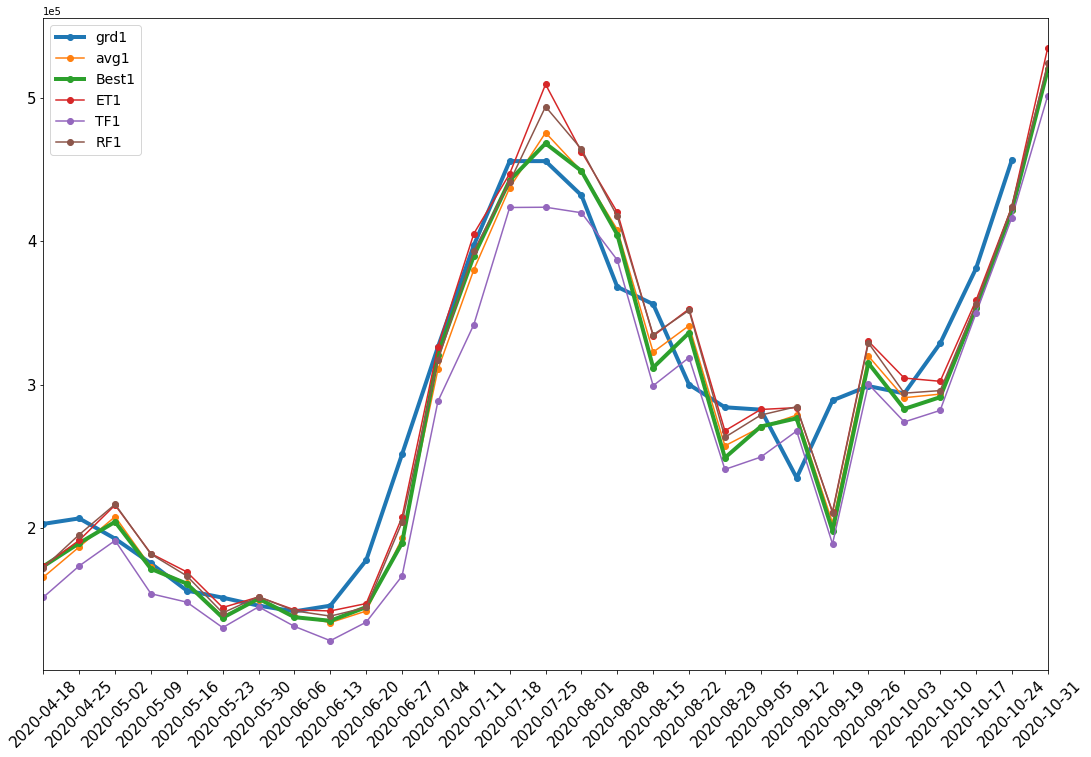

In [55]:
ylim = np.array([np.nanmin(df_count.values), np.nanmax(df_count.values)])
margin = (ylim[1] - ylim[0]) * .05
ylim = [ylim[0] - margin, ylim[1] + margin]

# fig, axes = plt.subplots(1, 1, figsize=(18, 12),sharex=True)
fig, ax = plt.subplots(1, 1, figsize=(18, 12),sharex=True)
for i in [1]:#, 2]:
    # ax = axes[i - 1]
    xtl = xtls[i - 1]
    df_count[[f'grd{i}']].plot(ax=ax, marker='o', linewidth=4)
    df_count[[f'avg{i}']].plot(ax=ax, marker='o')
    df_count[[f'Best{i}']].plot(ax=ax, marker='o', linewidth=4)
    for method in ['ET', 'TF', 'RF']:
        tmp_df = df_count[[f'{method}{i}']]
        tmp_df.plot(ax=ax, marker='o')
        
    ax.set_ylim(ylim)
    ax.set_xticks(range(len(xtl)))
    ax.set_xticklabels(xtl, rotation=45, ha='center')
    
    ax.ticklabel_format(axis='y', style='sci', scilimits=(0, 0))
    ax.tick_params(axis='both', labelsize=15)
    ax.legend(prop=dict(size=14))

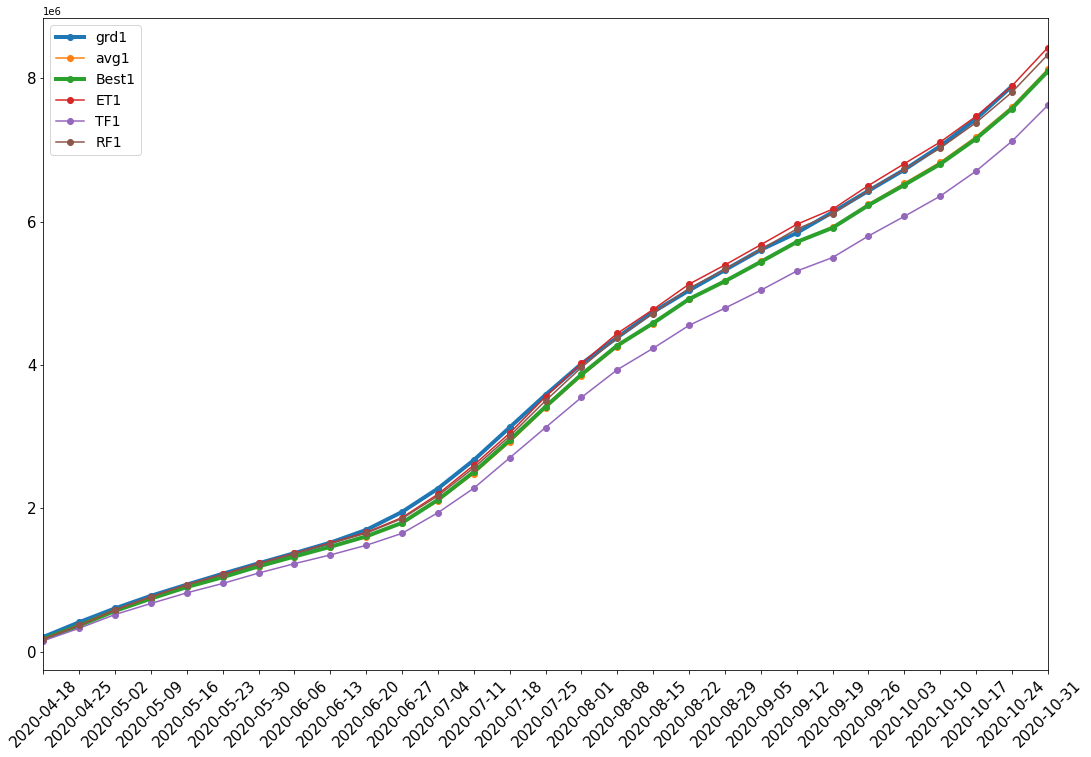

In [56]:
df_count_cumul = df_count.cumsum(axis=0)
ylim = np.array([np.nanmin(df_count_cumul.values), np.nanmax(df_count_cumul.values)])
margin = (ylim[1] - ylim[0]) * .05
ylim = [ylim[0] - margin, ylim[1] + margin]

# fig, axes = plt.subplots(2, 1, figsize=(18, 12), sharex=True)
fig, ax = plt.subplots(1, 1, figsize=(18, 12), sharex=True)
for i in [1]:#, 2]:
    # ax = axes[i - 1]
    xtl = xtls[i - 1]
    df_count_cumul[[f'grd{i}']].plot(ax=ax, marker='o', linewidth=4)
    df_count_cumul[[f'avg{i}']].plot(ax=ax, marker='o')
    df_count_cumul[[f'Best{i}']].plot(ax=ax, marker='o', linewidth=4)
    for method in ['ET', 'TF', 'RF']:
        tmp_df = df_count_cumul[[f'{method}{i}']]
        tmp_df.plot(ax=ax, marker='o')
    
    ax.set_ylim(ylim)
    
    ax.set_xticks(range(len(xtl)))
    ax.set_xticklabels(xtl, rotation=45, ha='center')
    
    ax.ticklabel_format(axis='y', style='sci', scilimits=(0, 0))
    ax.tick_params(axis='both', labelsize=15)
    ax.legend(prop=dict(size=14))

In [57]:
df_count.to_csv(f'forecast_ours_{plan}_1.csv', float_format='%0.f')